In [1]:

import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report

In [2]:
def load_audio_metadata(csv_path):
    df = pd.read_csv(csv_path)
    return df["File Path"].tolist(), df["Classification"].tolist()


# Step 2: Extract MFCC + LPC features
def extract_mfcc_lpc_features(paths, labels, n_mfcc=20, sr=22050, duration=10, lpc_order=12, top_db=25):
    """
    Removes silence using librosa.effects.trim before feature extraction.
    """
    features = []
    valid_labels = []

    for path, label in zip(paths, labels):
        try:
            # Load audio
            y, _ = librosa.load(path, sr=sr)

            #  Remove silence (energy below `top_db` dB from peak)
            y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)

            # Optional: ensure consistent duration
            if len(y_trimmed) < sr * duration:
                # pad short clips with zeros
                y_trimmed = np.pad(y_trimmed, (0, sr * duration - len(y_trimmed)))
            else:
                # take first `duration` seconds
                y_trimmed = y_trimmed[:sr * duration]

            # --- MFCC features ---
            mfcc = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=n_mfcc)
            mfcc_mean = np.mean(mfcc.T, axis=0)
            mfcc_std = np.std(mfcc.T, axis=0)
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta_mean = np.mean(mfcc_delta.T, axis=0)

            # --- LPC features ---
            lpc_coeffs = librosa.lpc(y_trimmed, order=lpc_order)
            lpc_features = np.concatenate([
                lpc_coeffs,
                np.abs(lpc_coeffs),
                np.log1p(np.abs(lpc_coeffs))
            ])

            # --- Combine all ---
            feature_vector = np.concatenate([mfcc_mean, mfcc_std, lpc_features])
            features.append(feature_vector)
            valid_labels.append(label)

        except Exception as e:
            print(f"Error processing {path}: {e}")

    return pd.DataFrame(features), pd.Series(valid_labels)

# Step 3: Encode labels & split data

def prepare_data(X, y, test_size=0.2, random_state=42):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return train_test_split(X, y_encoded, test_size=test_size, random_state=random_state), le


# Step 4: Evaluate model
def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test)
    print("\nAccuracy on test set:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


# Step 5: Benchmark classifiers
def benchmark_models(X_train, X_test, y_train, y_test, label_encoder):
    """
    Train and evaluate multiple models with per-model classification reports.
    """
    models = {
        "SVM": SVC(kernel="rbf", class_weight="balanced", random_state=42),
        "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
        "NaiveBayes": GaussianNB(),
        "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42),
        "MLP": MLPClassifier(hidden_layer_sizes=(150,), max_iter=500, random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
    }

    results = []

    for name, model in models.items():
        print(f"\n==============================")
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        results.append({
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc
        })

        print(f"\n {name} Results:")
        print(f"Train Accuracy: {train_acc:.3f}")
        print(f"Test Accuracy : {test_acc:.3f}\n")

        print(" Classification Report:")
        print(classification_report(
            y_test, y_test_pred,
            target_names=label_encoder.classes_,
            digits=3
        ))

    return pd.DataFrame(results)

# Step 6: Main pipeline

def run_audio_classification_pipeline(csv_path="classified_audios.csv"):
    print(" Loading metadata...")
    paths, labels = load_audio_metadata(csv_path)

    print(" Extracting MFCC + LPC features...")
    X, y = extract_mfcc_lpc_features(paths, labels)

    print(" Normalizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(" Splitting data...")
    (X_train, X_test, y_train, y_test), le = prepare_data(X_scaled, y)

    print("\n Benchmarking models...")
    results_df = benchmark_models(X_train, X_test, y_train, y_test,le)

    print("\n Model Comparison:")
    print(results_df.sort_values(by="Test Accuracy", ascending=False))

    # Optionally print best model
    best_model = results_df.loc[results_df["Test Accuracy"].idxmax()]
    print(f"\n Best Model: {best_model['Model']} with Test Accuracy = {best_model['Test Accuracy']:.3f}")

# Run
run_audio_classification_pipeline("classified_audios_auto.csv")

 Loading metadata...
 Extracting MFCC + LPC features...
 Normalizing features...
 Splitting data...

 Benchmarking models...

Training SVM...

 SVM Results:
Train Accuracy: 0.610
Test Accuracy : 0.531

 Classification Report:
              precision    recall  f1-score   support

        High      0.217     0.325     0.260        77
         Low      0.672     0.648     0.659       281
      Medium      0.520     0.449     0.482       207

    accuracy                          0.531       565
   macro avg      0.470     0.474     0.467       565
weighted avg      0.554     0.531     0.540       565


Training AdaBoost...


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



 AdaBoost Results:
Train Accuracy: 0.609
Test Accuracy : 0.558

 Classification Report:
              precision    recall  f1-score   support

        High      0.273     0.078     0.121        77
         Low      0.617     0.730     0.669       281
      Medium      0.493     0.502     0.498       207

    accuracy                          0.558       565
   macro avg      0.461     0.437     0.429       565
weighted avg      0.525     0.558     0.531       565


Training NaiveBayes...

 NaiveBayes Results:
Train Accuracy: 0.129
Test Accuracy : 0.142

 Classification Report:
              precision    recall  f1-score   support

        High      0.137     1.000     0.241        77
         Low      1.000     0.004     0.007       281
      Medium      0.667     0.010     0.019       207

    accuracy                          0.142       565
   macro avg      0.601     0.338     0.089       565
weighted avg      0.760     0.142     0.043       565


Training XGBoost...

 XGBoost Res

c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



 MLP Results:
Train Accuracy: 0.993
Test Accuracy : 0.499

 Classification Report:
              precision    recall  f1-score   support

        High      0.240     0.156     0.189        77
         Low      0.616     0.612     0.614       281
      Medium      0.415     0.473     0.442       207

    accuracy                          0.499       565
   macro avg      0.424     0.414     0.415       565
weighted avg      0.491     0.499     0.493       565


Training CatBoost...

 CatBoost Results:
Train Accuracy: 1.000
Test Accuracy : 0.566

 Classification Report:
              precision    recall  f1-score   support

        High      0.000     0.000     0.000        77
         Low      0.623     0.765     0.687       281
      Medium      0.491     0.507     0.499       207

    accuracy                          0.566       565
   macro avg      0.371     0.424     0.395       565
weighted avg      0.490     0.566     0.524       565


 Model Comparison:
        Model  Train Ac

In [3]:



# Step 2: Extract MFCC + LPC features without silence trimming
def extract_mfcc_lpc_features_notrim(paths, labels, n_mfcc=20, sr=22050, duration=10, lpc_order=12):
    features = []
    valid_labels = []

    for path, label in zip(paths, labels):
        try:
            y, _ = librosa.load(path, sr=sr, duration=duration)

            # --- MFCC features ---
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            mfcc_mean = np.mean(mfcc.T, axis=0)
            mfcc_std = np.std(mfcc.T, axis=0)
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta_mean = np.mean(mfcc_delta.T, axis=0)

            # --- LPC features ---
            lpc_coeffs = librosa.lpc(y, order=lpc_order)
            lpc_features = np.concatenate([
                lpc_coeffs,
                np.abs(lpc_coeffs),
                np.log1p(np.abs(lpc_coeffs))
            ])

            # --- Combine all ---
            feature_vector = np.concatenate([mfcc_mean, mfcc_std, lpc_features])
            features.append(feature_vector)
            valid_labels.append(label)

        except Exception as e:
            print(f"Error processing {path}: {e}")

    return pd.DataFrame(features), pd.Series(valid_labels)


def run_audio_classification_pipeline(csv_path="classified_audios.csv"):
    print(" Loading metadata...")
    paths, labels = load_audio_metadata(csv_path)

    print(" Extracting MFCC + LPC features...")
    X, y = extract_mfcc_lpc_features_notrim(paths, labels)

    print(" Normalizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(" Splitting data...")
    (X_train, X_test, y_train, y_test), le = prepare_data(X_scaled, y)

    print("\n Benchmarking models...")
    results_df = benchmark_models(X_train, X_test, y_train, y_test,le)

    print("\n Model Comparison:")
    print(results_df.sort_values(by="Test Accuracy", ascending=False))

    # Optionally print best model
    best_model = results_df.loc[results_df["Test Accuracy"].idxmax()]
    print(f"\n Best Model: {best_model['Model']} with Test Accuracy = {best_model['Test Accuracy']:.3f}")

# Run
run_audio_classification_pipeline("classified_audios_auto.csv")

 Loading metadata...
 Extracting MFCC + LPC features...
 Normalizing features...
 Splitting data...

 Benchmarking models...

Training SVM...

 SVM Results:
Train Accuracy: 0.635
Test Accuracy : 0.538

 Classification Report:
              precision    recall  f1-score   support

        High      0.284     0.429     0.342        77
         Low      0.685     0.619     0.650       281
      Medium      0.497     0.469     0.483       207

    accuracy                          0.538       565
   macro avg      0.489     0.505     0.492       565
weighted avg      0.562     0.538     0.547       565


Training AdaBoost...


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



 AdaBoost Results:
Train Accuracy: 0.620
Test Accuracy : 0.575

 Classification Report:
              precision    recall  f1-score   support

        High      0.345     0.130     0.189        77
         Low      0.656     0.705     0.679       281
      Medium      0.500     0.565     0.531       207

    accuracy                          0.575       565
   macro avg      0.500     0.467     0.466       565
weighted avg      0.556     0.575     0.558       565


Training NaiveBayes...

 NaiveBayes Results:
Train Accuracy: 0.131
Test Accuracy : 0.140

 Classification Report:
              precision    recall  f1-score   support

        High      0.137     1.000     0.241        77
         Low      0.000     0.000     0.000       281
      Medium      0.500     0.010     0.019       207

    accuracy                          0.140       565
   macro avg      0.212     0.337     0.087       565
weighted avg      0.202     0.140     0.040       565


Training XGBoost...


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


 XGBoost Results:
Train Accuracy: 1.000
Test Accuracy : 0.561

 Classification Report:
              precision    recall  f1-score   support

        High      0.333     0.052     0.090        77
         Low      0.615     0.712     0.660       281
      Medium      0.496     0.546     0.520       207

    accuracy                          0.561       565
   macro avg      0.481     0.437     0.423       565
weighted avg      0.533     0.561     0.531       565


Training MLP...


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



 MLP Results:
Train Accuracy: 1.000
Test Accuracy : 0.503

 Classification Report:
              precision    recall  f1-score   support

        High      0.194     0.156     0.173        77
         Low      0.627     0.633     0.630       281
      Medium      0.429     0.454     0.441       207

    accuracy                          0.503       565
   macro avg      0.417     0.414     0.415       565
weighted avg      0.495     0.503     0.499       565


Training CatBoost...

 CatBoost Results:
Train Accuracy: 1.000
Test Accuracy : 0.565

 Classification Report:
              precision    recall  f1-score   support

        High      0.250     0.026     0.047        77
         Low      0.630     0.726     0.674       281
      Medium      0.485     0.546     0.514       207

    accuracy                          0.565       565
   macro avg      0.455     0.433     0.412       565
weighted avg      0.525     0.565     0.530       565


 Model Comparison:
        Model  Train Ac

 Loading metadata...
 Extracting MFCC + LPC features...
 Normalizing features...


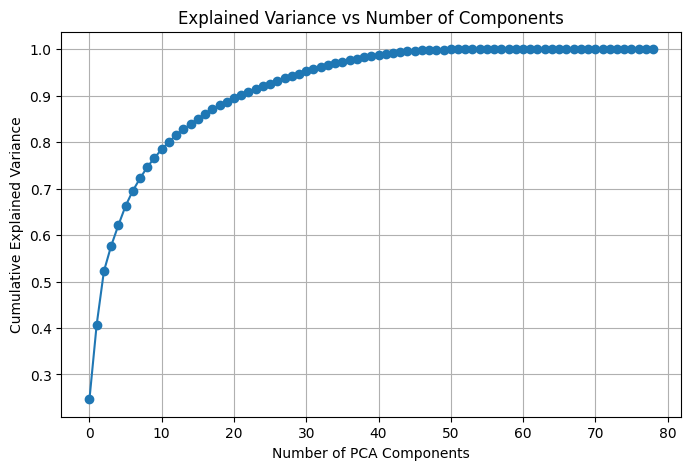

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

print(" Loading metadata...")
paths, labels = load_audio_metadata("classified_audios_auto.csv")

print(" Extracting MFCC + LPC features...")
X, y = extract_mfcc_lpc_features_notrim(paths, labels)

print(" Normalizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Assume X_scaled is normalized
pca_temp = PCA().fit(X_scaled)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_temp.explained_variance_ratio_), marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

In [6]:
#PCA with 95% variance
pca = PCA(n_components=40, random_state=42)  
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced features from {X_scaled.shape[1]} ➜ {X_pca.shape[1]} dimensions")
(X_train, X_test, y_train, y_test), le = prepare_data(X_pca, y)
print("\n Benchmarking models...")
results_df = benchmark_models(X_train, X_test, y_train, y_test,le)

print("\n Model Comparison:")
print(results_df.sort_values(by="Test Accuracy", ascending=False))

# Optionally print best model
best_model = results_df.loc[results_df["Test Accuracy"].idxmax()]
print(f"\n Best Model: {best_model['Model']} with Test Accuracy = {best_model['Test Accuracy']:.3f}")




PCA reduced features from 79 ➜ 40 dimensions

 Benchmarking models...

Training SVM...

 SVM Results:
Train Accuracy: 0.638
Test Accuracy : 0.529

 Classification Report:
              precision    recall  f1-score   support

        High      0.277     0.403     0.328        77
         Low      0.668     0.616     0.641       281
      Medium      0.490     0.459     0.474       207

    accuracy                          0.529       565
   macro avg      0.478     0.492     0.481       565
weighted avg      0.549     0.529     0.537       565


Training AdaBoost...


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



 AdaBoost Results:
Train Accuracy: 0.620
Test Accuracy : 0.549

 Classification Report:
              precision    recall  f1-score   support

        High      0.323     0.130     0.185        77
         Low      0.635     0.662     0.648       281
      Medium      0.473     0.551     0.509       207

    accuracy                          0.549       565
   macro avg      0.477     0.448     0.447       565
weighted avg      0.533     0.549     0.534       565


Training NaiveBayes...

 NaiveBayes Results:
Train Accuracy: 0.354
Test Accuracy : 0.322

 Classification Report:
              precision    recall  f1-score   support

        High      0.154     0.714     0.254        77
         Low      0.624     0.431     0.509       281
      Medium      0.400     0.029     0.054       207

    accuracy                          0.322       565
   macro avg      0.393     0.391     0.273       565
weighted avg      0.478     0.322     0.308       565


Training XGBoost...

 XGBoost Res

c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



 MLP Results:
Train Accuracy: 1.000
Test Accuracy : 0.515

 Classification Report:
              precision    recall  f1-score   support

        High      0.262     0.208     0.232        77
         Low      0.625     0.598     0.611       281
      Medium      0.455     0.517     0.484       207

    accuracy                          0.515       565
   macro avg      0.447     0.441     0.442       565
weighted avg      0.513     0.515     0.513       565


Training CatBoost...

 CatBoost Results:
Train Accuracy: 1.000
Test Accuracy : 0.556

 Classification Report:
              precision    recall  f1-score   support

        High      0.250     0.013     0.025        77
         Low      0.616     0.737     0.671       281
      Medium      0.471     0.512     0.491       207

    accuracy                          0.556       565
   macro avg      0.446     0.421     0.395       565
weighted avg      0.513     0.556     0.517       565


 Model Comparison:
        Model  Train Ac

 Loading metadata...

 Extracting MFCC + LPC (time-sliced)...

Total slices extracted: 36634

 Class distribution after slicing:
Low       16655
Medium    15007
High       4972
Name: count, dtype: int64

 Normalizing features...

 Applying PCA (95% variance)...
PCA reduced features to 40 dimensions

Splitting data...

 Benchmarking models...

 Training SVM...
 SVM Accuracy: 0.548
 SVM train Accuracy: 0.596
              precision    recall  f1-score   support

        High       0.28      0.48      0.36       963
         Low       0.65      0.61      0.63      3374
      Medium       0.59      0.50      0.54      2990

    accuracy                           0.55      7327
   macro avg       0.51      0.53      0.51      7327
weighted avg       0.58      0.55      0.56      7327


 Training AdaBoost...


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


 AdaBoost Accuracy: 0.543
 AdaBoost train Accuracy: 0.551
              precision    recall  f1-score   support

        High       0.31      0.03      0.05       963
         Low       0.58      0.63      0.60      3374
      Medium       0.51      0.61      0.56      2990

    accuracy                           0.54      7327
   macro avg       0.47      0.42      0.40      7327
weighted avg       0.52      0.54      0.51      7327


 Training NaiveBayes...
 NaiveBayes Accuracy: 0.260
 NaiveBayes train Accuracy: 0.266
              precision    recall  f1-score   support

        High       0.14      0.79      0.24       963
         Low       0.62      0.31      0.41      3374
      Medium       0.57      0.04      0.07      2990

    accuracy                           0.26      7327
   macro avg       0.44      0.38      0.24      7327
weighted avg       0.54      0.26      0.25      7327


 Training XGBoost...
 XGBoost Accuracy: 0.603
 XGBoost train Accuracy: 0.869
              p

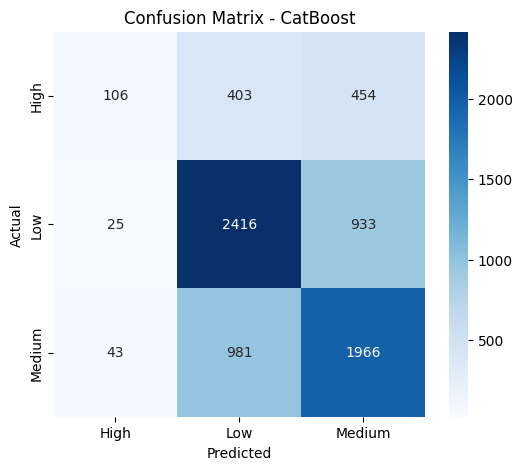

In [16]:

#pca with timeslice
from sklearn.metrics import confusion_matrix
import seaborn as sns
# --------------------------
# Step 1: Load metadata
# --------------------------
def load_audio_metadata(csv_path):
    df = pd.read_csv(csv_path)
    return df["File Path"].tolist(), df["Classification"].tolist()

# --------------------------
# Step 2: Feature extraction with time slicing
# --------------------------
def extract_mfcc_lpc_features_timesliced(
    paths, labels, n_mfcc=20, sr=22050, duration=10,
    lpc_order=12, slice_duration=1.0, overlap=0.5
):
    """
    Extract MFCC + LPC features from overlapping slices of each audio file.
    Each slice is treated as a separate data sample.
    """
    features, valid_labels = [], []

    for path, label in zip(paths, labels):
        try:
            y, _ = librosa.load(path, sr=sr, duration=duration)
            total_len = len(y)
            slice_len = int(slice_duration * sr)
            hop_len = int(slice_len * (1 - overlap))

            # Slice through the signal
            for start in range(0, total_len - slice_len + 1, hop_len):
                slice_y = y[start:start + slice_len]
                if len(slice_y) < lpc_order + 1:
                    continue

                # MFCC
                mfcc = librosa.feature.mfcc(y=slice_y, sr=sr, n_mfcc=n_mfcc)
                mfcc_mean = np.mean(mfcc.T, axis=0)
                mfcc_std = np.std(mfcc.T, axis=0)
                mfcc_delta = librosa.feature.delta(mfcc)
                mfcc_delta_mean = np.mean(mfcc_delta.T, axis=0)

                # LPC
                lpc_coeffs = librosa.lpc(y, order=lpc_order)
                lpc_features = np.concatenate([
                lpc_coeffs,
                np.abs(lpc_coeffs),
                np.log1p(np.abs(lpc_coeffs))
                ])

                # Combine features
                feature_vector = np.concatenate([mfcc_mean, mfcc_std, lpc_features])
                features.append(feature_vector)
                valid_labels.append(label)

        except Exception as e:
            print(f"Error processing {path}: {e}")

    print(f"\nTotal slices extracted: {len(features)}")
    return pd.DataFrame(features), pd.Series(valid_labels)

# --------------------------
# Step 3: Prepare data
# --------------------------
def prepare_data(X, y, test_size=0.2, random_state=42):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return train_test_split(X, y_encoded, test_size=test_size, random_state=random_state), le

# --------------------------
# Step 4: Model evaluation
# --------------------------
def benchmark_models(X_train, X_test, y_train, y_test, label_encoder):
    models = {
        "SVM": SVC(kernel="rbf", class_weight="balanced", random_state=42),
        "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
        "NaiveBayes": GaussianNB(),
        "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42),
        "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
    }

    results = []
    trained_models = {}
    for name, model in models.items():
        print(f"\n Training {name}...")
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_train_pred)
        acc = accuracy_score(y_test, y_pred)
        print(f" {name} Accuracy: {acc:.3f}")
        print(f" {name} train Accuracy: {train_acc:.3f}")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

        results.append({
            "Model": name,
            "Test Accuracy": acc,
            "Train Accuracy": train_acc
        })
        trained_models[name] = (model, y_pred)

    return pd.DataFrame(results),trained_models

# --------------------------
# Step 5: Run full pipeline
# --------------------------
def run_audio_classification_pipeline(csv_path="classified_audios.csv", use_pca=True):
    print(" Loading metadata...")
    paths, labels = load_audio_metadata(csv_path)

    print("\n Extracting MFCC + LPC (time-sliced)...")
    X, y = extract_mfcc_lpc_features_timesliced(
        paths, labels,
        slice_duration=1.0, overlap=0.5
    )

    # Show class distribution
    print("\n Class distribution after slicing:")
    print(y.value_counts())

    print("\n Normalizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if use_pca:
        print("\n Applying PCA (95% variance)...")
        pca = PCA(n_components=40, random_state=42)
        X_scaled = pca.fit_transform(X_scaled)
        print(f"PCA reduced features to {X_scaled.shape[1]} dimensions")

    print("\nSplitting data...")
    (X_train, X_test, y_train, y_test), le = prepare_data(X_scaled, y)

    print("\n Benchmarking models...")
    results_df,trained_models = benchmark_models(X_train, X_test, y_train, y_test, le)

    print("\n Model Comparison:")
    print(results_df.sort_values(by="Test Accuracy", ascending=False))

    best_model_row = results_df.loc[results_df["Test Accuracy"].idxmax()]
    best_model_name = best_model_row["Model"]
    print(f"\n Best Model: {best_model_name} ({best_model_row['Test Accuracy']:.3f})")
    best_model, y_pred = trained_models[best_model_name]
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {best_model_name}")
    plt.show()

# --------------------------
# Run
# --------------------------
run_audio_classification_pipeline("classified_audios_auto.csv", use_pca=True)


 Loading metadata...

 Extracting MFCC + LPC (time-sliced)...

Total slices extracted: 36634

 Class distribution after slicing:
Low       16655
Medium    15007
High       4972
Name: count, dtype: int64

 Normalizing features...

Splitting data...

 Benchmarking models...

 Training SVM...
 SVM Accuracy: 0.557
 SVM train Accuracy: 0.608
              precision    recall  f1-score   support

        High       0.29      0.50      0.37       963
         Low       0.66      0.61      0.64      3374
      Medium       0.60      0.51      0.55      2990

    accuracy                           0.56      7327
   macro avg       0.52      0.54      0.52      7327
weighted avg       0.59      0.56      0.57      7327


 Training AdaBoost...


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


 AdaBoost Accuracy: 0.561
 AdaBoost train Accuracy: 0.563
              precision    recall  f1-score   support

        High       0.55      0.07      0.12       963
         Low       0.60      0.64      0.62      3374
      Medium       0.53      0.63      0.57      2990

    accuracy                           0.56      7327
   macro avg       0.56      0.45      0.44      7327
weighted avg       0.56      0.56      0.53      7327


 Training NaiveBayes...
 NaiveBayes Accuracy: 0.138
 NaiveBayes train Accuracy: 0.143
              precision    recall  f1-score   support

        High       0.13      1.00      0.23       963
         Low       1.00      0.00      0.01      3374
      Medium       0.77      0.01      0.03      2990

    accuracy                           0.14      7327
   macro avg       0.63      0.34      0.09      7327
weighted avg       0.79      0.14      0.04      7327


 Training XGBoost...
 XGBoost Accuracy: 0.964
 XGBoost train Accuracy: 0.991
              p

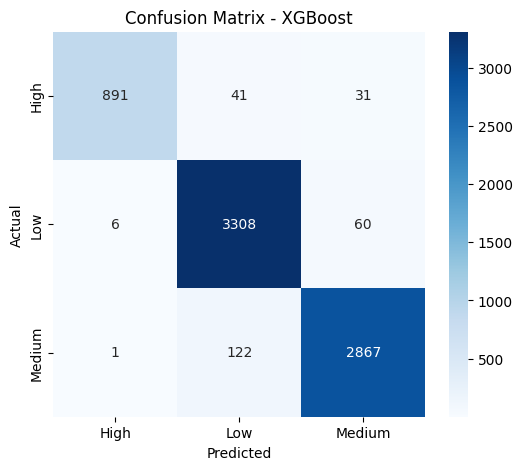

In [18]:
# no pca with timeslice
def run_audio_classification_pipeline(csv_path="classified_audios.csv", use_pca=False):
    print(" Loading metadata...")
    paths, labels = load_audio_metadata(csv_path)

    print("\n Extracting MFCC + LPC (time-sliced)...")
    X, y = extract_mfcc_lpc_features_timesliced(
        paths, labels,
        slice_duration=1.0, overlap=0.5
    )

    # Show class distribution
    print("\n Class distribution after slicing:")
    print(y.value_counts())

    print("\n Normalizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if use_pca:
        print("\n Applying PCA (95% variance)...")
        pca = PCA(n_components=40, random_state=42)
        X_scaled = pca.fit_transform(X_scaled)
        print(f"PCA reduced features to {X_scaled.shape[1]} dimensions")

    print("\nSplitting data...")
    (X_train, X_test, y_train, y_test), le = prepare_data(X_scaled, y)

    print("\n Benchmarking models...")
    results_df,trained_models = benchmark_models(X_train, X_test, y_train, y_test, le)

    print("\n Model Comparison:")
    print(results_df.sort_values(by="Test Accuracy", ascending=False))

    best_model_row = results_df.loc[results_df["Test Accuracy"].idxmax()]
    best_model_name = best_model_row["Model"]
    print(f"\n Best Model: {best_model_name} ({best_model_row['Test Accuracy']:.3f})")
    best_model, y_pred = trained_models[best_model_name]
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {best_model_name}")
    plt.show()


# --------------------------
# Run
# --------------------------
run_audio_classification_pipeline("classified_audios_auto.csv", False)

In [ ]:
# less slice duration + silence removal
from tqdm import tqdm

def extract_mfcc_lpc_features_timesliced(
    paths, labels, n_mfcc=20, sr=22050,
    slice_duration=0.5, overlap=0.5,
    lpc_order=12, rms_threshold=1e-4
):
    features, valid_labels = [], []

    slice_len = int(slice_duration * sr)
    hop_len = int(slice_len * (1 - overlap))

    for path, label in tqdm(zip(paths, labels), total=len(paths), desc="Extracting features"):
        try:
            # Load full audio
            y, _ = librosa.load(path, sr=sr)
            y = librosa.effects.trim(y, top_db=25)[0]  # quick global silence trim

            # Slice the signal
            for start in range(0, len(y) - slice_len + 1, hop_len):
                slice_y = y[start:start + slice_len]

                # Skip silent slices
                if librosa.feature.rms(y=slice_y).mean() < rms_threshold:
                    continue

                # --- MFCC ---
                mfcc = librosa.feature.mfcc(y=slice_y, sr=sr, n_mfcc=n_mfcc)
                mfcc_mean = np.mean(mfcc.T, axis=0)
                mfcc_std = np.std(mfcc.T, axis=0)

                # Adaptive delta (handles short slices)
                if mfcc.shape[1] > 1:
                    delta_width = min(9, mfcc.shape[1] - 1)
                    mfcc_delta = librosa.feature.delta(mfcc, width=delta_width)
                    mfcc_delta_mean = np.mean(mfcc_delta.T, axis=0)
                else:
                    mfcc_delta_mean = np.zeros_like(mfcc_mean)

                # --- LPC ---
                if len(slice_y) > lpc_order:
                    lpc_coeffs = librosa.lpc(slice_y, order=lpc_order)
                    lpc_features = np.concatenate([
                        lpc_coeffs,
                        np.abs(lpc_coeffs),
                        np.log1p(np.abs(lpc_coeffs))
                    ])
                else:
                    lpc_features = np.zeros(lpc_order * 3)

                # --- Combine ---
                feature_vector = np.concatenate([mfcc_mean, mfcc_std, mfcc_delta_mean, lpc_features])
                features.append(feature_vector)
                valid_labels.append(label)

        except Exception as e:
            print(f"Error processing {path}: {e}")

    print(f" Extracted {len(features)} slices (after silence removal)")
    return pd.DataFrame(features), pd.Series(valid_labels)

def run_audio_classification_pipeline(csv_path="classified_audios.csv", use_pca=True):
    print(" Loading metadata...")
    paths, labels = load_audio_metadata(csv_path)

    print(" Extracting MFCC + LPC (time-sliced, silence-removed)...")
    X, y = extract_mfcc_lpc_features_timesliced(paths, labels, slice_duration=0.5, overlap=0.5)

    # Show class distribution
    print("\n Class distribution after slicing:")
    print(y.value_counts())

    print("\n Normalizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if use_pca:
        print("\n Applying PCA (95% variance)...")
        pca = PCA(n_components=0.95, random_state=42)
        X_scaled = pca.fit_transform(X_scaled)
        print(f"PCA reduced features to {X_scaled.shape[1]} dimensions")

    print("\nSplitting data...")
    (X_train, X_test, y_train, y_test), le = prepare_data(X_scaled, y)

    print("\n Benchmarking models...")
    results_df = benchmark_models(X_train, X_test, y_train, y_test, le)

    print("\n Model Comparison:")
    print(results_df.sort_values(by="Test Accuracy", ascending=False))

    best_model = results_df.loc[results_df["Test Accuracy"].idxmax()]
    print(f"\n Best Model: {best_model['Model']} ({best_model['Test Accuracy']:.3f})")

# --------------------------
# Run
# --------------------------
run_audio_classification_pipeline("classified_audios_auto.csv", use_pca=True)

 Loading metadata...
 Extracting MFCC + LPC (time-sliced, silence-removed)...


Extracting features: 100%|██████████| 2825/2825 [36:56<00:00,  1.27it/s]  


 Extracted 151190 slices (after silence removal)

 Class distribution after slicing:
Low       66121
Medium    61987
High      23082
Name: count, dtype: int64

 Normalizing features...

 Applying PCA (95% variance)...
PCA reduced features to 50 dimensions

Splitting data...

 Benchmarking models...

 Training SVM...
